This is the 7th simple toy model to adapt the LLH NN from Ice Cube to tracker geometry. We're using a more realistic detector model now with 32 detector layers separated into 32 bins. The layers are stacked straight, not following the curve of the ring, and tracks are curved. Each bin registers hit/no hit with 100% efficiency, and the distance from the straw center as a Gaussian random variable. Instead of using (z,p,phi), we are now using (x,z,p) and assume that phi=0 always. 

Training on large parameter range with 1e6 samples.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from scipy.special import erf
import types
from scipy.optimize import minimize, Bounds

from LLH_NN_utils import *

In [2]:
#layers at fixed z, giving x position
#source has x,z,px,pz
# B=1.45

#each tracker module has 4 layers of 32 straws, 8 modules in a station
#straw tube is 5mm diameter
#muons decay 5-10m from first layer
#momentum (0.5-3)e3 MeV
#300 mu-m radial position resolution
#4cm between outer layers of one module
#~6cm from center of module to edge?
#1mm between the two U-layers


#layers of 32 5mm bins, 1mm separated, 1cm between "twin" layers
#
# __ __ __ __
#__ __ __ __
#
#__ __ __ __
# __ __ __ __

#2cm between U and V, 4cm between modules

det_zs = np.ones((8,4))
det_zs[:,0] *= 0
det_zs[:,2] *= 3
det_zs[:,3] *= 4
for i in range(1,8):
    det_zs[i] += i*8
det_zs = det_zs.flatten()*1e-2
    
N_bins = 32
N_det = len(det_zs)

det_xs = np.tile(np.array([(i*6+2.5)*1e-3 for i in range(32)]),(N_det,1)) #i = z, j = x
#leftshift_idx = [1,2,5,6,9,10,13,14] #i//2 even and i%2 odd or i//2 odd and i%2 even
det_xs[[((i//2)%2 == 0 and (i%2) == 1) or ((i//2)%2 == 1 and (i%2) == 0) for i in range(N_det)]] -= 2.5e-3
det_xs += (4.5 + 2)*1e-2 #distance to storage volume center

### Tracker toy model

Muon decaying at (x,z), producing positron with momentum p in z-direction. $\vec{B} = B\hat{y}$

Since the Lorentz force only acts perpendicular to the direction of motion, $|v|$ and $\gamma$ don't change, and the time derivative is simply
$\frac{d\vec{v}}{dt} = \frac{q}{\gamma m} (\vec{v} \times \vec{B}) = \frac{qB}{\gamma m} (v_x \hat{z} - v_z\hat{x})$

$p_x = p\sin(\frac{qB}{\gamma m} t)$<br/>
$p_z = p\cos(\frac{qB}{\gamma m} t)$

$x = \int_0^T v_x dt = -\frac{\gamma m}{qB} |v| (\cos(\frac{qB}{\gamma m} T) - \frac{v_z(0)}{|v|})$<br/>
$z = \int_0^T v_z dt = \frac{\gamma m}{qB} |v| (\sin(\frac{qB}{\gamma m} T) - \frac{v_x(0)}{|v|})$

$z$ is fixed, so<br/>
$T = \frac{\gamma m}{qB}\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})$

$x = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\cos(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})) = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\sqrt{1 - (\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})^2} = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2|v|^2 - (qBz +\gamma mv_x(0))^2}$<br/>
$x = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2v_z^2(0) - q^2B^2z^2 -2qBz\gamma mv_x(0)} = \frac{p_z(0)}{qB} - \frac{1}{qB}\sqrt{p_z^2(0) - q^2B^2z^2 -2qBzp_x(0)}$

Change to use $|p|(0) = p$ and initial angle $\phi = 0$ (from the z-axis):<br/>
$x = \frac{p}{qB} - \frac{1}{qB}\sqrt{p^2 - q^2B^2z^2} + x(0) = \frac{p}{qB}(1 - \sqrt{1 - \frac{q^2B^2z^2}{p^2}}) + x(0)$

In [3]:
#leave out e in momentum calc, and q's above

c = constants.c
#e = constants.e
B = 1.45

def calc_x(x,z,p):
    # p is in GeV -> *1e9/c
    p = p*1e9/c
    
    sq = p**2 - B**2*z**2
    #take square root where possible
    sq[sq>=0] = np.sqrt(sq[sq>=0])
    
    res = (p - sq)/B + x
    res[sq<0] = -1

    return res

#example event x_toy,z_toy,p_toy
toy=[1e-3,-0.73,1.9] #this produces hits in almost every layer
#toy=[-1e-2,-0.64,2.3] #this is a flat event, leaving top layers w/o hits
x_toy, z_toy, p_toy = toy

#for Gaussian
sigma = 3e-4

d_hit = lambda x: stats.truncnorm(-x/sigma, np.inf, loc=x, scale=sigma)

In [4]:
def generate_event(x, z, p):
    # generates an event from given x, z, p
    # returns length N_det array of centers of hit bins, z-position of layer,
    # and distance from bin center
    
    hits = np.zeros((N_det,3))
    hits[:,1] = det_zs
    dist = det_zs-z
    x_exp = calc_x(x,dist,p)
    for i in range(N_det):
        #check if x_exp < or > than end of detector (incl. -1)
        if x_exp[i] < det_xs[i,0]-2.5e-3 or x_exp[i] > det_xs[i,-1]+2.5e-3: continue
        
        #figure out which bin it would hit
        j = (np.abs(det_xs[i] - x_exp[i])).argmin()
        #distance from bin center
        d = np.abs(x_exp[i]-det_xs[i,j])
        if d <= 2.5e-3:
            hits[i,0] = det_xs[i,j]
            #add distance
            hits[i,2] = d_hit(d).rvs()
    #if we drew a distance that's larger than bin radius, replace with outer edge
    hits[:,2][hits[:,2]>2.5e-3] = 2.5e-3
    
    return hits

def generate_expectation(x, z, p):
    # generates an event from given x, z, p
    # returns length N_det array of centers of hit bins, z-position of layer,
    # and distance from bin center (exact)
    
    hits = np.zeros((N_det,3))
    hits[:,1] = det_zs
    dist = det_zs-z
    x_exp = calc_x(x,dist,p)
    for i in range(N_det):
        #check if x_exp < or > than end of detector (incl. -1)
        if x_exp[i] < det_xs[i,0]-2.5e-3 or x_exp[i] > det_xs[i,-1]+2.5e-3: continue
        
        #figure out which bin it would hit
        j = (np.abs(det_xs[i] - x_exp[i])).argmin()
        #distance from bin center
        d = np.abs(x_exp[i]-det_xs[i,j])
        if d <= 2.5e-3:
            hits[i,0] = det_xs[i,j]
            #add distance
            hits[i,2] = d
    
    return hits

#toy MC
def MC_events(N_events, xlims=(-2.5e-2,2.5e-2), zlims=(-1, -0.5), plims=(0.5,3.0),verbose_lvl = 0):
    '''
    sample source parameters from uniform distribution of x, z, and p #isn't really uniform dist
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
        
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array x,z,p
    
    x = []
    z = []
    p = []
    events = []
    
    while len(events)<N_events:
        # number of events to go
        n_evs = N_events-len(events)
        if verbose_lvl == 2:
            print("# events done:",len(events))
            print("# events to go:",n_evs)
        _x = np.random.uniform(*xlims, n_evs)
        _z = np.random.uniform(*zlims, n_evs)
        _p = np.random.uniform(*plims, n_evs)
        for i in range(n_evs):
            _ev = generate_event(_x[i],_z[i],_p[i])
        
            #check if particle produces at least 5 hits (3 layers)
            if np.sum(_ev>0)>4:
                x.append(_x[i])
                z.append(_z[i])
                p.append(_p[i])
                events.append(_ev)
                if verbose_lvl >= 1:
                    if len(events)%(N_events//10) == 0: print(N_events//10,"events done")
        if verbose_lvl == 2:
            print("# events thrown out:",N_events - len(events))
    
    truth = np.asarray((x, z, p)).T
    assert truth.shape[0] == len(events)
        
    return events, truth

In [5]:
def plot_event(ev):
    #plt scatter, then scatter event in red on top
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for i in range(N_det):
        ax.scatter(det_xs[i],np.ones(N_bins)*det_zs[i],marker="_",s=100,color="grey")
    ax.scatter(ev[:,0][ev[:,0]>0],det_zs[ev[:,0]>0],marker="_",s=100,color="red")
    ax.set_xlabel('x [m]')
    ax.set_ylabel('z [m]')

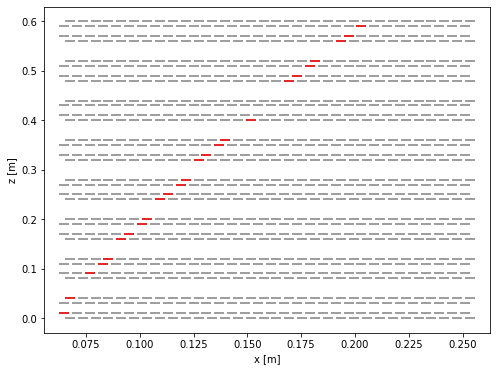

In [6]:
ev = generate_event(*toy)
#print(ev)
plot_event(ev)

In [7]:
#log-likelihoods

#hit/no hit is delta function, so probability is 1 if should be hit, 0 if shouldn't be hit
def hit_pdf(ev,x,z,p):
    x_meas = ev[:,0]
    d_meas = ev[:,2]
    x_exp = calc_x(x,det_zs-z,p)
    ev_exp = generate_expectation(x,z,p)
    
    llh = 0
    
    for i,hit in enumerate(x_meas):
        #if we didn't register a hit and should have,
        #or registered a hit and shouldn't have or different bin,
        #likelihood will be zero
        if hit != ev_exp[i,0]:
            llh = -710
            break
        #if we registered a hit and it's supposed to be a hit
        elif hit>0 and hit == ev_exp[i,0]:
            llh -= (d_meas[i]-ev_exp[i,2])**2/(2*sigma**2) + np.log(sigma)
        #if we didn't register a hit
    #store negative LLH, multiply by -1
    return -llh

In [8]:
grid_spacing = 10000

#full range
xs = np.linspace(-2.5e-2, 2.5e-2, grid_spacing)
zs = np.linspace(-1, -0.5, grid_spacing)
ps = np.linspace(0.5, 3.0, grid_spacing)

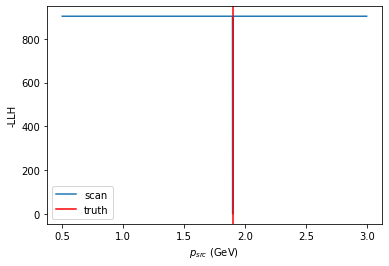

In [28]:
llh_p_scan = map_1d(hit_pdf, ev, 2, ps, toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

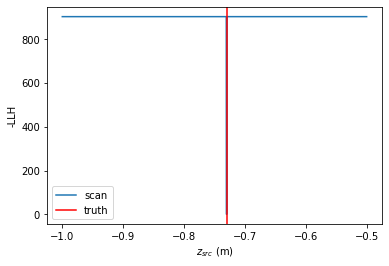

In [29]:
llh_z_scan = map_1d(hit_pdf, ev, 1, zs, toy)

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

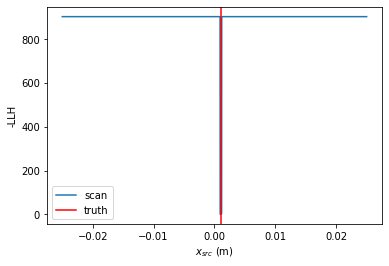

In [30]:
llh_x_scan = map_1d(hit_pdf, ev, 0, xs, toy)

plot_1d_scan(llh_x_scan, xs, x_toy, '$x_{src}$ (m)')

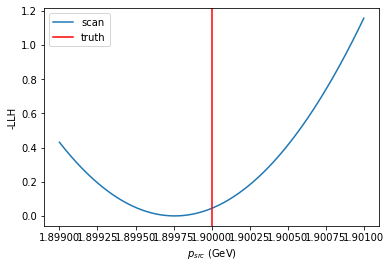

In [34]:
#zooming in
p_zoom = np.array([-1e-3,1e-3])+p_toy
ps = np.linspace(*p_zoom, grid_spacing)

llh_p_scan = map_1d(hit_pdf, ev, 2, ps, toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

In [9]:
#make toy MC data for neural net training
N_mc = int(1e6)
mc, truth = MC_events(N_mc,verbose_lvl=2)

# events done: 0
# events to go: 1000000
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
# events thrown out: 0


In [59]:
#neural nets

hitnet = types.SimpleNamespace() 

hitnet.events = mc

#separate the hits into single events, add number of non-zero hits
hitnet.events = np.concatenate(hitnet.events)

hitnet.truth = np.repeat(truth, N_det, axis=0)

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

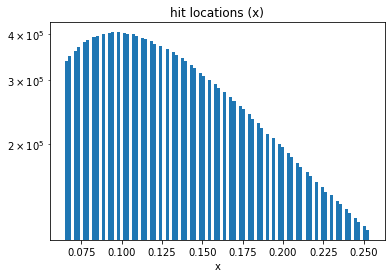

In [60]:
plt.hist(hitnet.events[:,0][hitnet.events[:,0]>0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [61]:
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        #out = tf.stack([
        #         hits[:,0],
        #         hits[:,1],
        #         hits[:,2],
        #         #hits[:,3],
        #         theta[:,0],
        #         theta[:,1],
        #         theta[:,2]
        #        ],
        #        axis=1
        #        )
        #out = tf.concat([hits[:,:1],r2,theta],axis=1)
        out = tf.concat([hits,theta],axis=1)
        return out

hitnet.trafo = trafo

In [62]:
#make training and test datasets

hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)

In [63]:
activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo_2 (trafo)                 (None, 6)            0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 32)           224         trafo_2[0][0]              

In [64]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [65]:
hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=5, verbose=1, validation_data=hitnet.d_test)

Epoch 1/5
12500/12500 [==============================] - 776s 62ms/step - loss: 0.3703 - val_loss: 0.4356
Epoch 2/5
12500/12500 [==============================] - 880s 70ms/step - loss: 0.3262 - val_loss: 0.3113
Epoch 3/5
12500/12500 [==============================] - 911s 73ms/step - loss: 0.3207 - val_loss: 0.3079
Epoch 4/5
12500/12500 [==============================] - 829s 66ms/step - loss: 0.3166 - val_loss: 0.3067
Epoch 5/5
12500/12500 [==============================] - 766s 61ms/step - loss: 0.3149 - val_loss: 0.3111


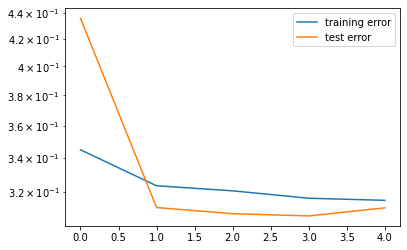

In [66]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

#compile neural net
#log(sigmoid) = linear -> change last layer to get llh
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

In [67]:
grid_spacing = 100

#full range
xs = np.linspace(-2.5e-2, 2.5e-2, grid_spacing)
zs = np.linspace(-1, -0.5, grid_spacing)
ps = np.linspace(0.5, 3.0, grid_spacing)

#len_ev = np.sum(ev[:,0]>0)

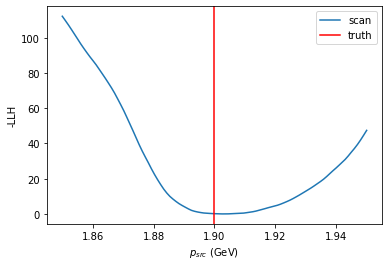

In [72]:
#neural net scan
p_zoom = np.array([-0.05,0.05]) + p_toy #0.1
ps = np.linspace(*p_zoom, grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*x_toy,np.ones(grid_spacing)*z_toy,ps]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev[:,0],grid_spacing)
scan_x = np.vstack((scan_x,np.tile(ev[:,1],grid_spacing),np.tile(ev[:,2],grid_spacing))).T

nn_p_scan = hitnet.llh.predict([scan_x,scan_t])

nn_p_scan = -np.sum(nn_p_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_p_scan, ps, p_toy, axis_label='$p_{src}$ (GeV)')

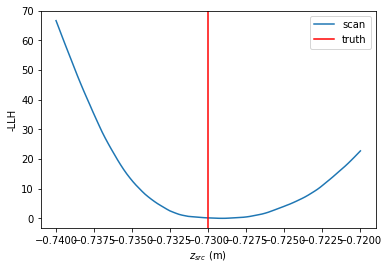

In [73]:
#neural net scan
z_zoom = np.array([-0.01,0.01]) + z_toy #0.015
zs = np.linspace(*z_zoom, grid_spacing)

scan_t = np.vstack([np.ones(grid_spacing)*x_toy,zs,np.ones(grid_spacing)*p_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

nn_z_scan = -np.sum(nn_z_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_z_scan, zs, z_toy, axis_label='$z_{src}$ (m)')

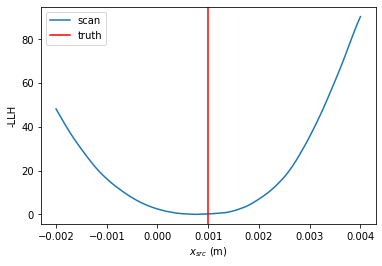

In [74]:
#neural net scan
x_zoom = np.array([-0.003,0.003]) + x_toy
xs = np.linspace(*x_zoom, grid_spacing)

scan_t = np.vstack([xs,np.ones(grid_spacing)*z_toy,np.ones(grid_spacing)*p_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

nn_x_scan = hitnet.llh.predict([scan_x,scan_t])

nn_x_scan = -np.sum(nn_x_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_x_scan, xs, x_toy, axis_label='$x_{src}$ (m)')

Full range scan looks like sharper point than previously? But zoomed in the actual minimum is relatively flat.

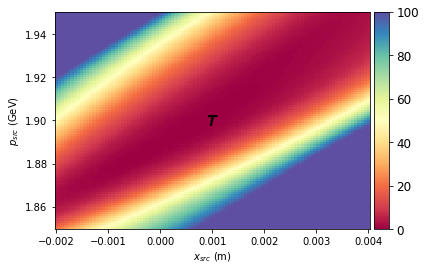

In [75]:
#neural net scan
mg = np.meshgrid(xs,ps)

hitnet.grid_t = np.vstack([mg[0].flatten(),np.ones(grid_spacing**2)*z_toy,mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev[:,0],grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(ev[:,1],grid_spacing**2),np.tile(ev[:,2],grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_x_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_x_p_scan, xs, ps, x_toy, p_toy, 
            axis_labels=['$x_{src}$ (m)','$p_{src}$ (GeV)'], vmax=100)

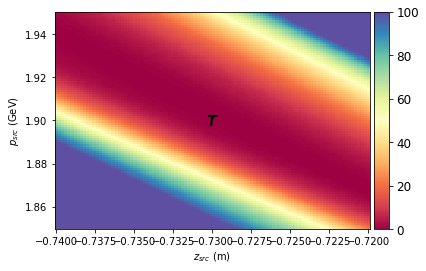

In [76]:
#neural net scan
mg = np.meshgrid(zs,ps)

hitnet.grid_t = np.vstack([np.ones(grid_spacing**2)*x_toy,mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_p_scan, zs, ps, z_toy, p_toy, 
            axis_labels=['$z_{src}$ (m)', '$p_{src}$ (GeV)'], vmax=100)

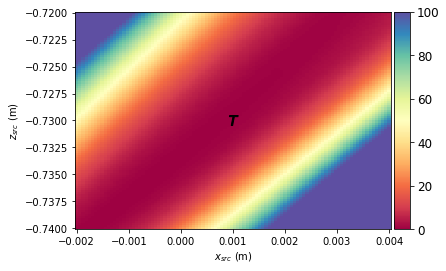

In [77]:
#neural net scan
mg = np.meshgrid(xs,zs)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*p_toy]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_x_z_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_x_z_scan, xs, zs, x_toy, z_toy, 
            axis_labels=['$x_{src}$ (m)', '$z_{src}$ (m)'], vmax=100)

In [78]:
#minimize nn output
def llh_fct(theta,event):
    #wrapper function
    
    #event is nx2 array
    len_ev = np.sum(event[:,0]>0)
    
    #repeat truth for each hit in event
    theta = np.array(theta)
    params = np.repeat(theta[np.newaxis,:], N_det, axis=0) 
    
    #let neural net predict llh for each event, sum is total llh
    pred = hitnet.llh.predict([event,params])
    return -np.sum(pred)

print(*toy)
true_llh_nn = llh_fct(toy,ev)
print(true_llh_nn)

0.001 -0.73 1.9
-83.74603


In [79]:
def bound_min(min_fct, x0, bounds, ev):
    #run a bound minimizer
    
    #x0 starting guess
    #bounds must be list of tuples, len = len(x0)
    opt_params = minimize(min_fct,x0,args=(ev),method='Powell',bounds=bounds,options={'maxiter':100000})
    
    print("starting guess:",x0)
    if opt_params.success:
        print("function value:",opt_params.fun)
        print("\nerrors:")
        print("x (mm):",1000*(opt_params.x[0]-x_toy))
        print("z (mm):",1000*(opt_params.x[1]-z_toy))
        print("p (MeV):",1000*(opt_params.x[2]-p_toy))
        print("\nrelative error (%):")
        print(100*(opt_params.x - [x_toy,z_toy,p_toy])/[x_toy,z_toy,p_toy])
        print("\n")
        
    else: print("Minimization failed!")
        
    return opt_params.fun, opt_params.x

In [80]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(llh_fct,[-2.5e-2,-1,0.5],[(-2.5e-2,2.5e-2),(-1,-0.5),(0.5,3.0)],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth:",true_llh_nn)
    print("NN llh of found min:",f_nn)

starting guess: [-0.025, -1, 0.5]
function value: -78.827835

errors:
x (mm): 23.999428978097793
z (mm): 208.85802387718067
p (MeV): -385.0122975802792

relative error (%):
[2399.94289781  -28.6106882   -20.26380514]




In [85]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(llh_fct,[2.5e-2,-0.5,3.0],[(-2.5e-2,2.5e-2),(-1,-0.5),(0.5,3.0)],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth:",true_llh_nn)
    print("NN llh of found min:",f_nn)

starting guess: [0.025, -0.5, 3.0]
function value: -85.08837

errors:
x (mm): -8.781796997143893
z (mm): -68.47579861010999
p (MeV): 121.09773562145998

relative error (%):
[-878.17969971    9.38024638    6.37356503]


LLH of truth: -83.74603
NN llh of found min: -85.08837


In [87]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(llh_fct,[x_zoom[0],z_zoom[0],p_zoom[0]],[(-2.5e-2,2.5e-2),(-1,-0.5),(0.5,3.0)],ev)#[x_zoom,z_zoom,p_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth:",true_llh_nn)
    print("NN llh of found min:",f_nn)

starting guess: [-0.002, -0.74, 1.8499999999999999]
function value: -84.02077

errors:
x (mm): -1.4564029022979794
z (mm): -3.181843592193312
p (MeV): -7.862971934464946

relative error (%):
[-145.64029023    0.43586899   -0.41384063]


LLH of truth: -83.74603
NN llh of found min: -84.02077


In [88]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(llh_fct,[x_zoom[1],z_zoom[1],p_zoom[1]],[(-2.5e-2,2.5e-2),(-1,-0.5),(0.5,3.0)],ev)#[x_zoom,z_zoom,p_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth:",true_llh_nn)
    print("NN llh of found min:",f_nn)

starting guess: [0.004, -0.72, 1.95]
function value: -83.737625

errors:
x (mm): 1.8322629212294945
z (mm): 18.306983355313
p (MeV): -35.36518647176945

relative error (%):
[183.22629212  -2.50780594  -1.8613256 ]




In [89]:
#minimize NN output with different starting guesses
f_nn, opt_nn = bound_min(llh_fct,toy,[(-2.5e-2,2.5e-2),(-1,-0.5),(0.5,3.0)],ev)#[x_zoom,z_zoom,p_zoom],ev)
if f_nn<=true_llh_nn:
    print("LLH of truth:",true_llh_nn)
    print("NN llh of found min:",f_nn)

starting guess: [0.001, -0.73, 1.9]
function value: -83.96712

errors:
x (mm): -0.36660351423225646
z (mm): -0.17788380332561804
p (MeV): -1.019036954889918

relative error (%):
[-3.66603514e+01  2.43676443e-02 -5.36335239e-02]


LLH of truth: -83.74603
NN llh of found min: -83.96712


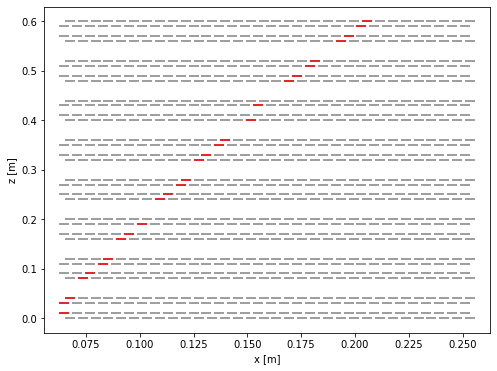

In [86]:
test_ev = generate_event(*opt_nn) #for second starting guess
plot_event(test_ev)

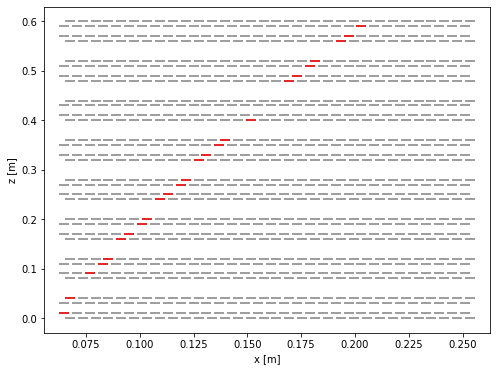

In [38]:
plot_event(ev)